! 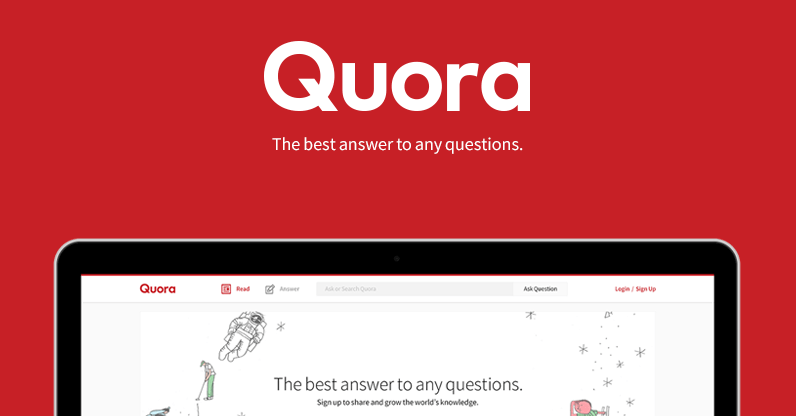


# **Predicting Similar Questions**



* For a given data we have to predict which of the provided pairs of questions contain two questions with the same meaning. 
* Suppose you ask a question on Quora, and get some suggested answers.These answers corrosponds to questions which are     similar to the one you have asked.



## Data-Set Desctiption

* id - the id of a training set question pair
* qid1, qid2 - unique ids of each question (only available in train.csv)
* question1, question2 - the full text of each question
* is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise


## Importing Required Libraries

In [4]:
import pandas as pd
import numpy as np

import re
from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

### Loading Data Set

In [5]:
quora_df = pd.read_csv(r"C:\Data\train.csv")

In [6]:
quora_df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


In [7]:
quora_df.tail(2)

,id,qid1,qid2,question1,question2,is_duplicate
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0
404289,404289,537932,537933,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0


In [8]:
quora_df.shape
quora_df.info()

(404290, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


###  **Removing Unnecessary Columns**

In [9]:
quora_df.drop('qid1',axis = 1,inplace=True)

In [10]:
quora_df.drop('qid2',axis=1,inplace=True)

In [11]:
quora_df.drop('id',axis=1,inplace=True)

### Printing few question pairs in the datset

In [12]:
for i in range(0,5):
    print(quora_df.question1[i])
    print(quora_df.question2[i])
    print()

What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?

What is the story of Kohinoor (Koh-i-Noor) Diamond?
What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?

How can I increase the speed of my internet connection while using a VPN?
How can Internet speed be increased by hacking through DNS?

Why am I mentally very lonely? How can I solve it?
Find the remainder when [math]23^{24}[/math] is divided by 24,23?

Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?
Which fish would survive in salt water?



# Exploratory Data Analysis



> **Check number of unique questions and duplicates in whole corpus**



In [13]:
questions_list = pd.concat([quora_df['question1'] , quora_df['question2']] )

unique_quesList = questions_list.value_counts()[questions_list.value_counts()==1].index

duplicate_quesList = questions_list.value_counts()[questions_list.value_counts()>1].index

print("Number of Questions which are unique: ",len(unique_quesList))
print("Number of Questions which are repeated: ",len(duplicate_quesList))
print("Total number of unique questions in dataset: ",len(questions_list.value_counts()))

Number of Questions which are unique:  425488
Number of Questions which are repeated:  111872
Total number of unique questions in dataset:  537360




> **Repeated Questions**



In [16]:
rep_ques = questions_list.value_counts()[questions_list.value_counts()>1]
rep_ques[0:8]

What are the best ways to lose weight?                                                                161
How can you look at someone's private Instagram account without following them?                       120
How can I lose weight quickly?                                                                        111
What's the easiest way to make money online?                                                           88
Can you see who views your Instagram?                                                                  79
What are some things new employees should know going into their first day at AT&T?                     77
What do you think of the decision by the Indian Government to demonetize 500 and 1000 rupee notes?     68
Which is the best digital marketing course?                                                            66
dtype: int64

### Identifying Questions types

In [17]:
pair = pd.Series(quora_df['question1'].tolist() + quora_df['question2'].tolist()).astype(str)

In [18]:
qmarks = np.mean(pair.apply(lambda x: '?' in x))
math = np.mean(pair.apply(lambda x: '[math]' in x))
fullstop = np.mean(pair.apply(lambda x: '.' in x))
capital_first = np.mean(pair.apply(lambda x: x[0].isupper()))
numbers = np.mean(pair.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

Questions with question marks: 99.87%
Questions with [math] tags: 0.12%
Questions with full stops: 6.31%
Questions with capitalised first letters: 99.81%
Questions with numbers: 11.83%




### **Handling Missing Values**



In [19]:
quora_df.duplicated().value_counts() # No Duplicates in our dataset

False    404290
dtype: int64

In [20]:
quora_df.isna().sum()

question1       1
question2       2
is_duplicate    0
dtype: int64

In [21]:
quora_df[quora_df.question1.isna()]
quora_df[quora_df.question2.isna()]

,question1,question2,is_duplicate
363362,NaN,My Chinese name is Haichao Yu. What English na...,0


,question1,question2,is_duplicate
105780,How can I develop android app?,NaN,0
201841,How can I create an Android app?,NaN,0


In [22]:
quora_df = quora_df.dropna(axis=0)

In [23]:
quora_df.isna().sum() # Done with missing values

question1       0
question2       0
is_duplicate    0
dtype: int64

In [24]:
quora_df.shape

(404287, 3)

## Imbalance in data

In [ ]:
quora_df.is_duplicate.value_counts(normalize=True) # Percentage of data 

0    0.630799
1    0.369201
Name: is_duplicate, dtype: float64

In [ ]:
quora_df.is_duplicate.value_counts()

0    255024
1    149263
Name: is_duplicate, dtype: int64

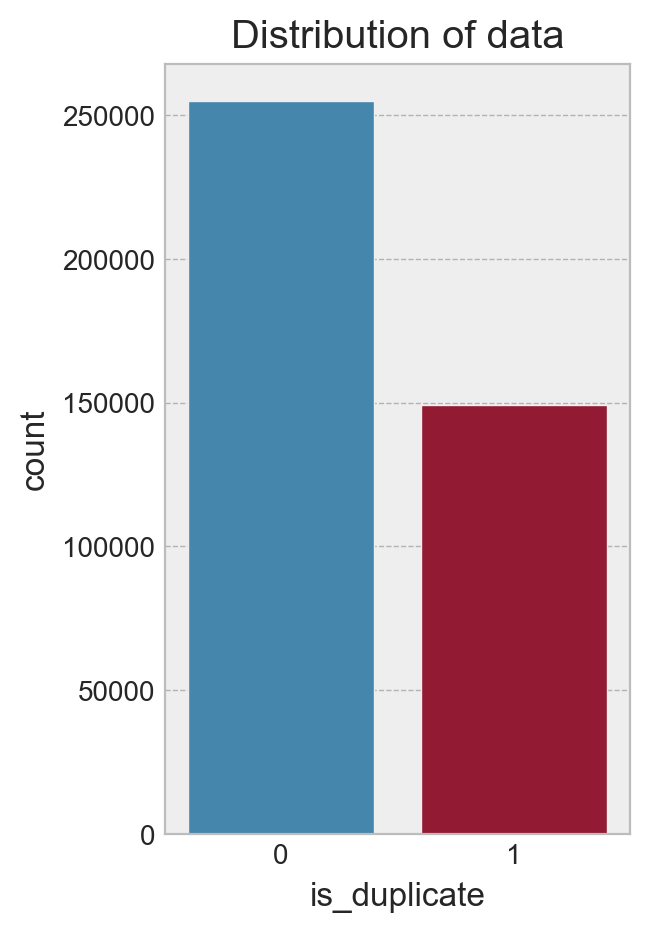

In [31]:
plt.figure(figsize=(3,5),dpi = 100)
plt.title('Distribution of data')
sns.countplot(x='is_duplicate', data=quora_df);

* we can observe that there is an imbalance in our data.
* 63% of our data is non-similar data and 36% is similar data 

## Text Preprocessing Steps

Text Preprocessing steps include some essential tasks to clean and remove the noise from the available data.

1. **Removing Special Characters and Punctuation**

2. **Converting to Lower Case** - We convert the whole text corpus to lower case to reduce the size of the vocabulary of our text data.

3. **Removing Stop Words** - Stopwords don't contribute to the meaning of a sentence. So, we can safely remove them without changing the meaning of the sentence. For eg: it, was, any, then, a, is, by, etc are the stopwords.

4. **Stemming** - Stemming is the process of getting the root form of a word. For eg: warm, warmer, warming can be converted to warm.

5. **Lemmatization** - Lemmatization takes a word and breaks it down to its lemma. For example, the verb "walk" might appear as "walking," "walks" or "walked." Inflectional endings such as "s," "ed" and "ing" are removed. 
    Lemmatization groups these words as its lemma, "walk."

In [32]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
  
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

In [33]:
# Applying text pre processing
quora_df['question1'] = quora_df['question1'].apply(preprocess)
quora_df['question2'] = quora_df['question2'].apply(preprocess)

## Data Preparation - Split the data into train and test set

In [34]:
quora_df.columns

Index(['question1', 'question2', 'is_duplicate'], dtype='object')

In [35]:
y = quora_df['is_duplicate']
X = quora_df[['question1','question2']]

In [36]:
# Splitting into train and test
from sklearn.model_selection import train_test_split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
X_train.head(1)
X_train.shape

,question1,question2
174950,india what are job options and future options...,jobs and careers in india i am currently in m...


(323429, 2)

In [39]:
X_test.head(1)
X_test.shape

,question1,question2
8067,how do i play pokémon go in korea,how do i play pokémon go in china


(80858, 2)

In [40]:
y_train.head(1)
y_train.shape

174950    0
Name: is_duplicate, dtype: int64

(323429,)

In [41]:
y_test.head(1)
y_test.shape

8067    0
Name: is_duplicate, dtype: int64

(80858,)

### - __Token__: You get a token by splitting sentence a space
### - __StopWord__: stop words as per NLTK.
### - __Word__ : A token that is not a stop_word

In [42]:
import nltk
nltk.download('stopwords')
# Downloading wordnet before applying Lemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prave\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\prave\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\prave\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\prave\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [43]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [44]:
!pip install tqdm

In [45]:
from tqdm import tqdm, tqdm_notebook 
# tqdm (taqadum) means progress and it is used to create a smart progress bar for the loops. 

In [46]:
tqdm.pandas()

## Applying ***Lemmatization*** Text Preprocessing technique on ***Train*** Data

In [49]:
## We can also use Lemmatizer instead of Stemmer
lemmatizer = WordNetLemmatizer()

In [50]:
def preprocessed(raw_text, flag):
    # Removing special characters and digits
    sentence = re.sub("[^a-zA-Z]", " ", raw_text)
    
    # change sentence to lower case
    sentence = sentence.lower()

    # tokenize into words
    tokens = sentence.split()
    
    # remove stop words                
    clean_tokens = [t for t in tokens if t not in stopwords.words("english")]
    
    # Stemming/Lemmatization
    if(flag == 'stem'):
        clean_tokens = [stemmer.stem(word) for word in clean_tokens]
    else:
        clean_tokens = [lemmatizer.lemmatize(word) for word in clean_tokens]
    
    return pd.Series([" ".join(clean_tokens), len(clean_tokens)])

In [51]:
l_temp_df = X_train['question1'].progress_apply(lambda x : preprocessed(x, 'lemma'))

100%|█████████████████████████████████████████████████████████████████████████| 323429/323429 [18:50<00:00, 286.19it/s]


In [ ]:
l_temp_df1 = X_train['question2'].progress_apply(lambda x : preprocessed(x, 'lemma'))

 68%|█████████████████████████████████████████████████▉                       | 221042/323429 [13:25<06:21, 268.47it/s]

In [ ]:
l_temp_df.columns = ['clean_text_lemma_Q1', 'text_length_lemma_Q1']
l_temp_df1.columns = ['clean_text_lemma_Q2', 'text_length_lemma_Q2']

In [ ]:
X_train = pd.concat([X_train, l_temp_df,l_temp_df1], axis=1)

X_train.head(2)

## Applying **`Lemmatization`** Text Preprocessing technique on ***Test*** Data

In [ ]:
l_temp_df = X_test['question1'].progress_apply(lambda x : preprocessed(x, 'lemma'))

In [ ]:
l_temp_df1 = X_test['question2'].progress_apply(lambda x : preprocessed(x, 'lemma'))

In [ ]:
l_temp_df.columns = ['clean_text_lemma_Q1', 'text_length_lemma_Q1']
l_temp_df1.columns = ['clean_text_lemma_Q2', 'text_length_lemma_Q2']

In [ ]:
X_test = pd.concat([X_test, l_temp_df,l_temp_df1], axis=1)

X_test.head(2)

## **Exporting**

In [ ]:
X_train.shape
X_train.info()

(323429, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323429 entries, 0 to 323428
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   question1             323415 non-null  object
 1   question2             323420 non-null  object
 2   clean_text_lemma_Q1   323292 non-null  object
 3   text_length_lemma_Q1  323429 non-null  int64 
 4   clean_text_lemma_Q2   323293 non-null  object
 5   text_length_lemma_Q2  323429 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 14.8+ MB


In [ ]:
X_test.shape
X_test.info()

(80858, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80858 entries, 0 to 80857
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   question1             80857 non-null  object
 1   question2             80858 non-null  object
 2   clean_text_lemma_Q1   80826 non-null  object
 3   text_length_lemma_Q1  80858 non-null  int64 
 4   clean_text_lemma_Q2   80819 non-null  object
 5   text_length_lemma_Q2  80858 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.7+ MB


In [ ]:
y_train.shape
y_test.shape

(323429, 1)

(80858, 1)

## Train Data

> Removing **NaN** Values


In [ ]:
X_train.isna().sum()
X_train.shape

question1                14
question2                 9
clean_text_lemma_Q1     137
text_length_lemma_Q1      0
clean_text_lemma_Q2     136
text_length_lemma_Q2      0
dtype: int64

(323429, 6)

In [ ]:
drop_list = X_train[(X_train.question1.isna()) 
                      | (X_train.question2.isna()) |(X_train.clean_text_lemma_Q1.isna())|(X_train.clean_text_lemma_Q2.isna())].index.to_list()

In [ ]:
X_train.drop(drop_list,axis = 0,inplace = True)

In [ ]:
X_train.reset_index(inplace = True,drop = 'first' )

In [ ]:
# Before dropping NaN values shape (323429, 6)
X_train.shape
X_train.info()

(323208, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323208 entries, 0 to 323207
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   question1             323208 non-null  object
 1   question2             323208 non-null  object
 2   clean_text_lemma_Q1   323208 non-null  object
 3   text_length_lemma_Q1  323208 non-null  int64 
 4   clean_text_lemma_Q2   323208 non-null  object
 5   text_length_lemma_Q2  323208 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 14.8+ MB


In [ ]:
# We have to remove the rows that present in X_train data
y_train.drop(drop_list,axis = 0,inplace = True)
y_train.reset_index(inplace = True, drop = 'first')

In [ ]:
# Before dropping NaN values shape (323429, 1)
y_train.shape
type(y_train)

(323208,)

pandas.core.series.Series

## Test Data

> Removing **NaN** Values


In [ ]:
X_test.isna().sum()
X_test.shape

question1                1
question2                0
clean_text_lemma_Q1     32
text_length_lemma_Q1     0
clean_text_lemma_Q2     39
text_length_lemma_Q2     0
dtype: int64

(80858, 6)

In [ ]:
drop_list = X_test[(X_test.question1.isna()) 
                      | (X_test.question2.isna()) |(X_test.clean_text_lemma_Q1.isna())|(X_test.clean_text_lemma_Q2.isna())].index.to_list()

In [ ]:
X_test.drop(drop_list,axis = 0,inplace = True)

In [ ]:
X_test.reset_index(inplace = True,drop = 'first')

In [ ]:
# Before dropping NaN values shape (80858, 6)
X_test.shape
X_test.info()

(80802, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80802 entries, 0 to 80801
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   question1             80802 non-null  object
 1   question2             80802 non-null  object
 2   clean_text_lemma_Q1   80802 non-null  object
 3   text_length_lemma_Q1  80802 non-null  int64 
 4   clean_text_lemma_Q2   80802 non-null  object
 5   text_length_lemma_Q2  80802 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.7+ MB


In [ ]:
# We have to remove the rows that present in X_test data
y_test.drop(drop_list,axis = 0,inplace = True)
y_test.reset_index(inplace = True, drop = 'first')

In [ ]:
# Before dropping NaN values shape (80858, 1)
y_test.shape
type(y_test)

(80802, 1)

pandas.core.frame.DataFrame

### **Cleaning questions**

In [ ]:
def preprocessing(raw_text):
    # Removing special characters and digits
    sentence = re.sub("[^a-zA-Z]", " ", raw_text)
    
    # change sentence to lower case
    sentence = sentence.lower()
    return pd.Series(sentence)

In [ ]:
X_train['clean_text_Q1'] = X_train['question1'].progress_apply(lambda x :preprocessing(x))

100%|██████████| 323208/323208 [00:55<00:00, 5773.77it/s] 


In [ ]:
X_train['clean_text_Q2'] = X_train['question2'].progress_apply(lambda x :preprocessing(x))

100%|██████████| 323208/323208 [00:50<00:00, 6380.66it/s] 


## **Tokenization**

In [ ]:
 import nltk
 nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
X_train['tokenizeQ1'] = X_train['clean_text_Q1'].progress_apply(nltk.word_tokenize)
X_train.head()

100%|██████████| 323208/323208 [00:42<00:00, 7561.03it/s] 


,question1,question2,clean_text_lemma_Q1,text_length_lemma_Q1,clean_text_lemma_Q2,text_length_lemma_Q2,clean_text_Q1,clean_text_Q2,tokenizeQ1
0,india what are job options and future options...,jobs and careers in india i am currently in m...,india job option future option low cgpa gradua...,12,job career india currently third year engineer...,28,india what are job options and future options...,jobs and careers in india i am currently in m...,"[india, what, are, job, options, and, future, ..."
1,which is world s best romantic movie,what is the best romantic movie of all time,world best romantic movie,4,best romantic movie time,4,which is world s best romantic movie,what is the best romantic movie of all time,"[which, is, world, s, best, romantic, movie]"
2,which is best place to live in hyderabad,which is best place to live hyderabad or mumbai,best place live hyderabad,4,best place live hyderabad mumbai,5,which is best place to live in hyderabad,which is best place to live hyderabad or mumbai,"[which, is, best, place, to, live, in, hyderabad]"
3,what should i do to be an athlete in a month,what is shop act licence,athlete month,2,shop act licence,3,what should i do to be an athlete in a month,what is shop act licence,"[what, should, i, do, to, be, an, athlete, in,..."
4,how do you learn to code on wordpress,in how much time can i learn to code a wordpre...,learn code wordpress,3,much time learn code wordpress website,6,how do you learn to code on wordpress,in how much time can i learn to code a wordpre...,"[how, do, you, learn, to, code, on, wordpress]"


In [ ]:
X_train['tokenizeQ2'] = X_train['clean_text_Q2'].progress_apply(nltk.word_tokenize)
X_train.head()

100%|██████████| 323208/323208 [00:42<00:00, 7663.78it/s]


,question1,question2,clean_text_lemma_Q1,text_length_lemma_Q1,clean_text_lemma_Q2,text_length_lemma_Q2,clean_text_Q1,clean_text_Q2,tokenizeQ1,tokenizeQ2
0,india what are job options and future options...,jobs and careers in india i am currently in m...,india job option future option low cgpa gradua...,12,job career india currently third year engineer...,28,india what are job options and future options...,jobs and careers in india i am currently in m...,"[india, what, are, job, options, and, future, ...","[jobs, and, careers, in, india, i, am, current..."
1,which is world s best romantic movie,what is the best romantic movie of all time,world best romantic movie,4,best romantic movie time,4,which is world s best romantic movie,what is the best romantic movie of all time,"[which, is, world, s, best, romantic, movie]","[what, is, the, best, romantic, movie, of, all..."
2,which is best place to live in hyderabad,which is best place to live hyderabad or mumbai,best place live hyderabad,4,best place live hyderabad mumbai,5,which is best place to live in hyderabad,which is best place to live hyderabad or mumbai,"[which, is, best, place, to, live, in, hyderabad]","[which, is, best, place, to, live, hyderabad, ..."
3,what should i do to be an athlete in a month,what is shop act licence,athlete month,2,shop act licence,3,what should i do to be an athlete in a month,what is shop act licence,"[what, should, i, do, to, be, an, athlete, in,...","[what, is, shop, act, licence]"
4,how do you learn to code on wordpress,in how much time can i learn to code a wordpre...,learn code wordpress,3,much time learn code wordpress website,6,how do you learn to code on wordpress,in how much time can i learn to code a wordpre...,"[how, do, you, learn, to, code, on, wordpress]","[in, how, much, time, can, i, learn, to, code,..."


## **Part-of-speech tagging**

Part-of-speech tagging (***POS tagging***) is the task of tagging a word in a text with its part of speech.

> A part of speech is a category of words with similar grammatical properties. Common English parts of speech are noun, verb, adjective, adverb, pronoun, preposition, conjunction, etc.



In [ ]:
X_train['pos_tagsQ1'] = X_train['tokenizeQ1'].progress_apply(nltk.pos_tag)
X_train.head()

100%|██████████| 323208/323208 [04:43<00:00, 1140.15it/s]


,question1,question2,clean_text_lemma_Q1,text_length_lemma_Q1,clean_text_lemma_Q2,text_length_lemma_Q2,clean_text_Q1,clean_text_Q2,tokenizeQ1,tokenizeQ2,pos_tagsQ1
0,india what are job options and future options...,jobs and careers in india i am currently in m...,india job option future option low cgpa gradua...,12,job career india currently third year engineer...,28,india what are job options and future options...,jobs and careers in india i am currently in m...,"[india, what, are, job, options, and, future, ...","[jobs, and, careers, in, india, i, am, current...","[(india, VB), (what, WP), (are, VBP), (job, NN..."
1,which is world s best romantic movie,what is the best romantic movie of all time,world best romantic movie,4,best romantic movie time,4,which is world s best romantic movie,what is the best romantic movie of all time,"[which, is, world, s, best, romantic, movie]","[what, is, the, best, romantic, movie, of, all...","[(which, WDT), (is, VBZ), (world, NN), (s, NN)..."
2,which is best place to live in hyderabad,which is best place to live hyderabad or mumbai,best place live hyderabad,4,best place live hyderabad mumbai,5,which is best place to live in hyderabad,which is best place to live hyderabad or mumbai,"[which, is, best, place, to, live, in, hyderabad]","[which, is, best, place, to, live, hyderabad, ...","[(which, WDT), (is, VBZ), (best, RBS), (place,..."
3,what should i do to be an athlete in a month,what is shop act licence,athlete month,2,shop act licence,3,what should i do to be an athlete in a month,what is shop act licence,"[what, should, i, do, to, be, an, athlete, in,...","[what, is, shop, act, licence]","[(what, WP), (should, MD), (i, VB), (do, VB), ..."
4,how do you learn to code on wordpress,in how much time can i learn to code a wordpre...,learn code wordpress,3,much time learn code wordpress website,6,how do you learn to code on wordpress,in how much time can i learn to code a wordpre...,"[how, do, you, learn, to, code, on, wordpress]","[in, how, much, time, can, i, learn, to, code,...","[(how, WRB), (do, VB), (you, PRP), (learn, VB)..."


In [ ]:
X_train['pos_tagsQ2'] = X_train['tokenizeQ2'].progress_apply(nltk.pos_tag)
X_train.head()

100%|██████████| 323208/323208 [04:17<00:00, 1254.26it/s]


,question1,question2,clean_text_lemma_Q1,text_length_lemma_Q1,clean_text_lemma_Q2,text_length_lemma_Q2,clean_text_Q1,clean_text_Q2,tokenizeQ1,tokenizeQ2,pos_tagsQ1,pos_tagsQ2
0,india what are job options and future options...,jobs and careers in india i am currently in m...,india job option future option low cgpa gradua...,12,job career india currently third year engineer...,28,india what are job options and future options...,jobs and careers in india i am currently in m...,"[india, what, are, job, options, and, future, ...","[jobs, and, careers, in, india, i, am, current...","[(india, VB), (what, WP), (are, VBP), (job, NN...","[(jobs, NNS), (and, CC), (careers, NNS), (in, ..."
1,which is world s best romantic movie,what is the best romantic movie of all time,world best romantic movie,4,best romantic movie time,4,which is world s best romantic movie,what is the best romantic movie of all time,"[which, is, world, s, best, romantic, movie]","[what, is, the, best, romantic, movie, of, all...","[(which, WDT), (is, VBZ), (world, NN), (s, NN)...","[(what, WP), (is, VBZ), (the, DT), (best, JJS)..."
2,which is best place to live in hyderabad,which is best place to live hyderabad or mumbai,best place live hyderabad,4,best place live hyderabad mumbai,5,which is best place to live in hyderabad,which is best place to live hyderabad or mumbai,"[which, is, best, place, to, live, in, hyderabad]","[which, is, best, place, to, live, hyderabad, ...","[(which, WDT), (is, VBZ), (best, RBS), (place,...","[(which, WDT), (is, VBZ), (best, RBS), (place,..."
3,what should i do to be an athlete in a month,what is shop act licence,athlete month,2,shop act licence,3,what should i do to be an athlete in a month,what is shop act licence,"[what, should, i, do, to, be, an, athlete, in,...","[what, is, shop, act, licence]","[(what, WP), (should, MD), (i, VB), (do, VB), ...","[(what, WP), (is, VBZ), (shop, VBN), (act, JJ)..."
4,how do you learn to code on wordpress,in how much time can i learn to code a wordpre...,learn code wordpress,3,much time learn code wordpress website,6,how do you learn to code on wordpress,in how much time can i learn to code a wordpre...,"[how, do, you, learn, to, code, on, wordpress]","[in, how, much, time, can, i, learn, to, code,...","[(how, WRB), (do, VB), (you, PRP), (learn, VB)...","[(in, IN), (how, WRB), (much, JJ), (time, NN),..."


In [ ]:
X_test['question1_clean'] = X_test['question1'].progress_apply(lambda x: preprocessing(x))
X_test['question2_clean'] = X_test['question2'].progress_apply(lambda x: preprocessing(x))
X_test['tokenizeQ1'] = X_test['question1_clean'].progress_apply(nltk.word_tokenize)
X_test['tokenizeQ2'] = X_test['question2_clean'].progress_apply(nltk.word_tokenize)
X_test['pos_tagsQ1'] = X_test['tokenizeQ1'].progress_apply(nltk.pos_tag)
X_test['pos_tagsQ2'] = X_test['tokenizeQ2'].progress_apply(nltk.pos_tag)

100%|██████████| 80802/80802 [00:55<00:00, 1445.03it/s]


* CC    - Coordinating conjunction
* CD	- Cardinal number
* DT	- Determiner
* EX	- Existential there
* FW	- Foreign word
* IN	- Preposition or subordinating conjunction
* JJ	- Adjective
* JJR	- Adjective, comparative
* JJS	- Adjective, superlative
* LS	- List item marker
* MD	- Modal
* NN	- Noun, singular or mass
* NNS	- Noun, plural
* NNP	- Proper noun, singular
* NNPS	- Proper noun, plural
* PDT	- Predeterminer
* POS	- Possessive ending
* PRP	- Personal pronoun
* PRP$  - Possessive pronoun




* RB	- Adverb
* RBR	- Adverb, comparative
* RBS	- Adverb, superlative
* RP	- Particle
* SYM	- Symbol
* TO	- to
* UH	- Interjection
* VB	- Verb, base form
* VBD	- Verb, past tense
* VBG	- Verb, gerund or present participle
* VBN	- Verb, past participle
* VBP	- Verb, non-3rd person singular present
* VBZ	- Verb, 3rd person singular present
* WDT	- Wh-determiner
* WP	- Wh-pronoun
* WP$	- Possessive wh-pronoun
* WRB	- Wh-adverb

In [ ]:
X_train.iloc[0:11 , -1:] # extract only the last column as a data frame

,pos_tagsQ2
0,"[(jobs, NNS), (and, CC), (careers, NNS), (in, ..."
1,"[(what, WP), (is, VBZ), (the, DT), (best, JJS)..."
2,"[(which, WDT), (is, VBZ), (best, RBS), (place,..."
3,"[(what, WP), (is, VBZ), (shop, VBN), (act, JJ)..."
4,"[(in, IN), (how, WRB), (much, JJ), (time, NN),..."
5,"[(over, IN), (what, WP), (types, NNS), (of, IN..."
6,"[(why, WRB), (do, VBP), (not, RB), (we, PRP), ..."
7,"[(how, WRB), (do, VB), (you, PRP), (find, VB),..."
8,"[(can, MD), (i, VB), (do, VBP), (pan, VB), (ca..."
9,"[(when, WRB), (people, NNS), (sue, VBP), (the,..."


# Text to Numerical Representation

In [ ]:
# We have to convert into series Using Squeeze()

y_train = y_train.squeeze()
y_test = y_test.squeeze()

In [ ]:
# Classfication
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

In [ ]:
# Evaluation metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report ,confusion_matrix,f1_score

! 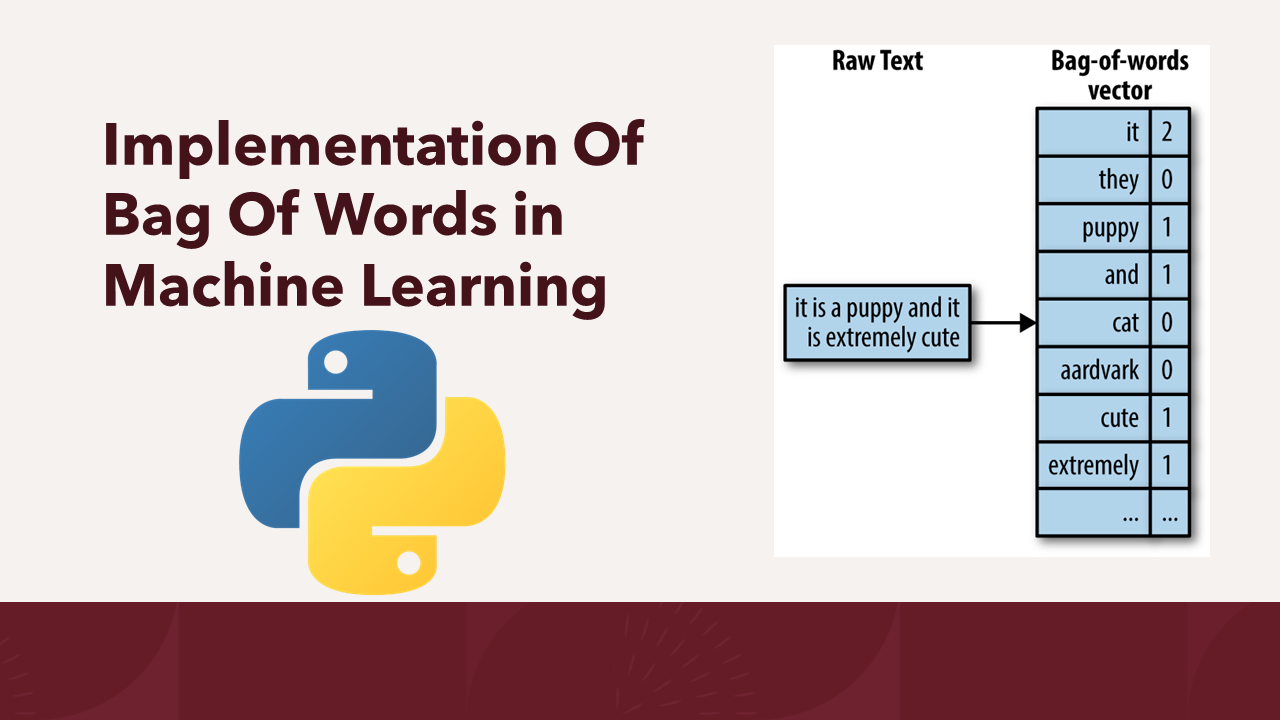

In [ ]:
X_train.head(1)

,question1,question2,clean_text_lemma_Q1,text_length_lemma_Q1,clean_text_lemma_Q2,text_length_lemma_Q2,clean_text_Q1,clean_text_Q2,tokenizeQ1,tokenizeQ2,pos_tagsQ1,pos_tagsQ2
0,india what are job options and future options...,jobs and careers in india i am currently in m...,india job option future option low cgpa gradua...,12,job career india currently third year engineer...,28,india what are job options and future options...,jobs and careers in india i am currently in m...,"['india', 'what', 'are', 'job', 'options', 'an...","['jobs', 'and', 'careers', 'in', 'india', 'i',...","[('india', 'VB'), ('what', 'WP'), ('are', 'VBP...","[('jobs', 'NNS'), ('and', 'CC'), ('careers', '..."


## **fit_transform()** does `two` functions: 
 * First, it fits the model and learns the vocabulary.
 * second, it transforms our training data into feature vectors. The input to fit_transform should be a list of strings.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
 
# Initialize the "CountVectorizer" object

vocab = CountVectorizer()

bow_train = vocab.fit_transform(X_train['clean_text_lemma_Q1']+X_train['clean_text_lemma_Q2'])
bow_test = vocab.transform(X_test['clean_text_lemma_Q1']+X_test['clean_text_lemma_Q2'])

In [ ]:
print("Total unique words:", len(vocab.vocabulary_))

print("Type of train features:", type(bow_train))

print("Shape of input data:", bow_train.shape)

Total unique words: 246541
Type of train features: <class 'scipy.sparse._csr.csr_matrix'>
Shape of input data: (323208, 246541)


In [ ]:
print("Total unique words:", len(vocab.vocabulary_))

print("Type of train features:", type(bow_test))

print("Shape of input data:", bow_test.shape)

Total unique words: 246541
Type of train features: <class 'scipy.sparse._csr.csr_matrix'>
Shape of input data: (80802, 246541)


 * We can look at unique words by using 'vocabulary_'
 * Observe that the type of variable is sparse.
 *  323208 documents and 246541 unique words Train Data
 *  80802 documents and 246541 unique words Test Data


# Model Building

## **Logistic Regression**

In [ ]:
classifier = LogisticRegression()
classifier.fit(bow_train, y_train)

LogisticRegression()

In [ ]:
y_test_pred = classifier.predict(bow_test)

In [ ]:
print(confusion_matrix(y_test, y_test_pred))
print(accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[44263  6717]
 [12404 17418]]
0.7633598178262915
              precision    recall  f1-score   support

           0       0.78      0.87      0.82     50980
           1       0.72      0.58      0.65     29822

    accuracy                           0.76     80802
   macro avg       0.75      0.73      0.73     80802
weighted avg       0.76      0.76      0.76     80802



## **Decision_Tree**

In [ ]:
classifier = DecisionTreeClassifier(max_depth=3)
classifier.fit(bow_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [ ]:
y_test_pred = classifier.predict(bow_test)

In [ ]:
print(confusion_matrix(y_test, y_test_pred))
print(accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))


[[50229   751]
 [27866  1956]]
0.6458379743075666
              precision    recall  f1-score   support

           0       0.64      0.99      0.78     50980
           1       0.72      0.07      0.12     29822

    accuracy                           0.65     80802
   macro avg       0.68      0.53      0.45     80802
weighted avg       0.67      0.65      0.54     80802



## **Gradient Boosting Decision tree (*GBDT*)**

In [ ]:
Classifier = GradientBoostingClassifier()
Classifier.fit(bow_train,y_train)

GradientBoostingClassifier()

In [ ]:
y_test_pred = classifier.predict(bow_test)

In [ ]:
print(confusion_matrix(y_test, y_test_pred))
print(accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))


[[50229   751]
 [27866  1956]]
0.6458379743075666
              precision    recall  f1-score   support

           0       0.64      0.99      0.78     50980
           1       0.72      0.07      0.12     29822

    accuracy                           0.65     80802
   macro avg       0.68      0.53      0.45     80802
weighted avg       0.67      0.65      0.54     80802



## **AdaBoost Classifier**

In [ ]:
classifier = AdaBoostClassifier()
classifier.fit(bow_train,y_train)

AdaBoostClassifier()

In [ ]:
y_test_pred = classifier.predict(bow_test)

In [ ]:
print(confusion_matrix(y_test, y_test_pred))
print(accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
D = f1_score(y_test, y_test_pred)

[[48406  2574]
 [23749  6073]]
0.6742283606841415
              precision    recall  f1-score   support

           0       0.67      0.95      0.79     50980
           1       0.70      0.20      0.32     29822

    accuracy                           0.67     80802
   macro avg       0.69      0.58      0.55     80802
weighted avg       0.68      0.67      0.61     80802



## **XGBoost Classifier**

In [ ]:
classifier = xgb.XGBClassifier()
classifier.fit(bow_train, y_train)
y_test_pred = classifier.predict(bow_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
print(confusion_matrix(y_test, y_test_pred))
print(accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
F = f1_score(y_test, y_test_pred)

[[48509  2471]
 [20253  9569]]
0.7187693373926388
              precision    recall  f1-score   support

           0       0.71      0.95      0.81     50980
           1       0.79      0.32      0.46     29822

    accuracy                           0.72     80802
   macro avg       0.75      0.64      0.63     80802
weighted avg       0.74      0.72      0.68     80802



# Conclusion

*  The results of the evaluation using `Accuracy` as the metric show that **`Logistic Regression`** outperformed the other models, with a score of **76**

* `XGBoost` had the second-best performance, with a score of **81.2**


####  These results suggest that **`Logistic Regression`** may be the most effective model for this particular task, 
      
> Although further evaluation and validation is necessary to confirm this conclusion.

! 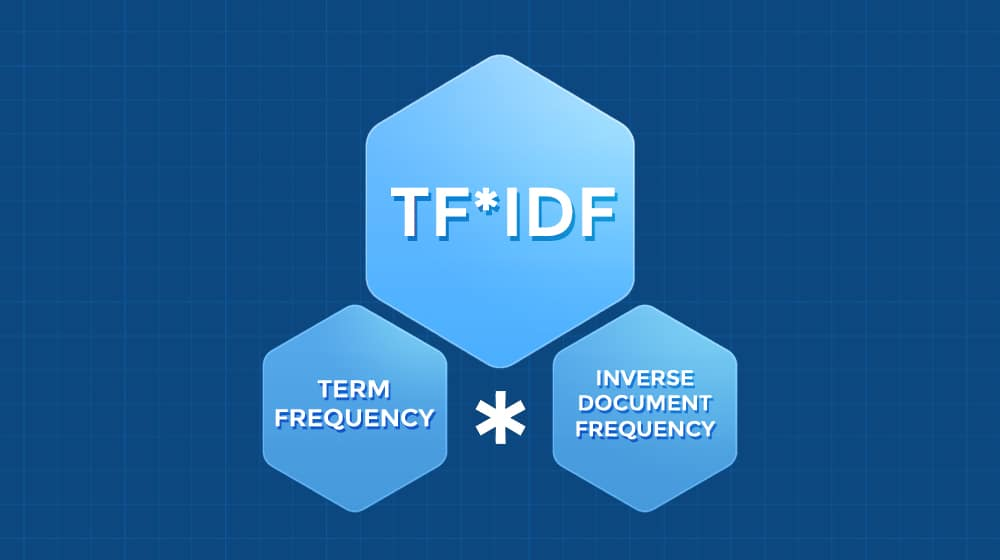

# **Term Frequency Inverse Document Frequency**


* In BOW approach all the words in the text are treated as equally important i.e. there's no notion of some words in the document being more important than others.
* TF-IDF, or term frequency-inverse document frequency, addresses this issue. 
* It aims to quantify the importance of a given word relative to other words in the document and in the corpus.



***

Let's now try to understand:
1. Term Frequency  
2. Inverse Document Frequency

$$ TF \ IDF = TF(word_i, doc_j) * IDF(word_i, corpus) $$

$$ TF(word_i, doc_j) = \frac{No \ of \ time \ word_i \ occurs \ in \ doc_j}{Total \ no \ of \ words \ in \ doc_j} $$

$$ IDF(word_i, corpus) = \log_n(\frac{No \ of \ docs \ in \ corpus}{No \ of \ docs \ which \ contains \ word_i}) $$

***



In [ ]:
X_train.head(1)

,question1,question2,clean_text_lemma_Q1,text_length_lemma_Q1,clean_text_lemma_Q2,text_length_lemma_Q2,clean_text_Q1,clean_text_Q2,tokenizeQ1,tokenizeQ2,pos_tagsQ1,pos_tagsQ2
0,india what are job options and future options...,jobs and careers in india i am currently in m...,india job option future option low cgpa gradua...,12,job career india currently third year engineer...,28,india what are job options and future options...,jobs and careers in india i am currently in m...,"['india', 'what', 'are', 'job', 'options', 'an...","['jobs', 'and', 'careers', 'in', 'india', 'i',...","[('india', 'VB'), ('what', 'WP'), ('are', 'VBP...","[('jobs', 'NNS'), ('and', 'CC'), ('careers', '..."


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

tf_train = vectorizer.fit_transform(X_train['clean_text_lemma_Q1'] + X_train['clean_text_lemma_Q2'])
tf_test = vectorizer.transform(X_test['clean_text_lemma_Q1'] + X_test['clean_text_lemma_Q2'])

In [ ]:
print("Total unique words:", len(vectorizer.vocabulary_))

print("Type of train features:", type(tf_train))

print("Shape of input data:", tf_train.shape)

Total unique words: 246541
Type of train features: <class 'scipy.sparse._csr.csr_matrix'>
Shape of input data: (323208, 246541)


# Model Building

## **Logistic Regression**

In [ ]:
classifier = LogisticRegression()
classifier.fit(tf_train, y_train)

LogisticRegression()

In [ ]:
y_test_pred = classifier.predict(tf_test)

In [ ]:
print(confusion_matrix(y_test, y_test_pred))
print(accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[44920  6060]
 [13851 15971]]
0.7535828321081162
              precision    recall  f1-score   support

           0       0.76      0.88      0.82     50980
           1       0.72      0.54      0.62     29822

    accuracy                           0.75     80802
   macro avg       0.74      0.71      0.72     80802
weighted avg       0.75      0.75      0.74     80802



## **Decision_Tree**

In [ ]:
classifier = DecisionTreeClassifier(max_depth=3)
classifier.fit(tf_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [ ]:
y_test_pred = classifier.predict(tf_test)

In [ ]:
print(confusion_matrix(y_test, y_test_pred))
print(accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))


[[48415  2565]
 [25586  4236]]
0.6516051582881612
              precision    recall  f1-score   support

           0       0.65      0.95      0.77     50980
           1       0.62      0.14      0.23     29822

    accuracy                           0.65     80802
   macro avg       0.64      0.55      0.50     80802
weighted avg       0.64      0.65      0.57     80802



## **Gradient Boosting Decision tree (*GBDT*)**

In [ ]:
classifier = GradientBoostingClassifier()
classifier.fit(tf_train,y_train)

GradientBoostingClassifier()

In [ ]:
y_test_pred = classifier.predict(tf_test)

In [ ]:
print(accuracy_score(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred)

0.6854038266379545
[[48397  2583]
 [22837  6985]]
              precision    recall  f1-score   support

           0       0.68      0.95      0.79     50980
           1       0.73      0.23      0.35     29822

    accuracy                           0.69     80802
   macro avg       0.70      0.59      0.57     80802
weighted avg       0.70      0.69      0.63     80802



## **AdaBoost Classifier**

In [ ]:
classifier = AdaBoostClassifier()
classifier.fit(tf_train,y_train)

AdaBoostClassifier()

In [ ]:
y_test_pred = classifier.predict(tf_test)

In [ ]:
print(accuracy_score(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))


0.6817529269077498
[[45518  5462]
 [20253  9569]]
              precision    recall  f1-score   support

           0       0.69      0.89      0.78     50980
           1       0.64      0.32      0.43     29822

    accuracy                           0.68     80802
   macro avg       0.66      0.61      0.60     80802
weighted avg       0.67      0.68      0.65     80802



## **XGBoost Classifier**

In [ ]:
classifier = xgb.XGBClassifier()
classifier.fit(tf_train, y_train)
y_test_pred = classifier.predict(tf_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
print(accuracy_score(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

0.7207247345362738
[[46749  4231]
 [18335 11487]]
              precision    recall  f1-score   support

           0       0.72      0.92      0.81     50980
           1       0.73      0.39      0.50     29822

    accuracy                           0.72     80802
   macro avg       0.72      0.65      0.66     80802
weighted avg       0.72      0.72      0.69     80802



# Conclusion

*  The results of the evaluation using `Accuracy` as the metric show that **`Logistic Regression`** outperformed the other models, with a score of **75**

* `XGBoost` had the second-best performance, with a score of **72**

####  These results suggest that **`Logistic Regression`** may be the most effective model for this particular task, 
   >  Although further evaluation and validation is necessary to confirm this conclusion.

! 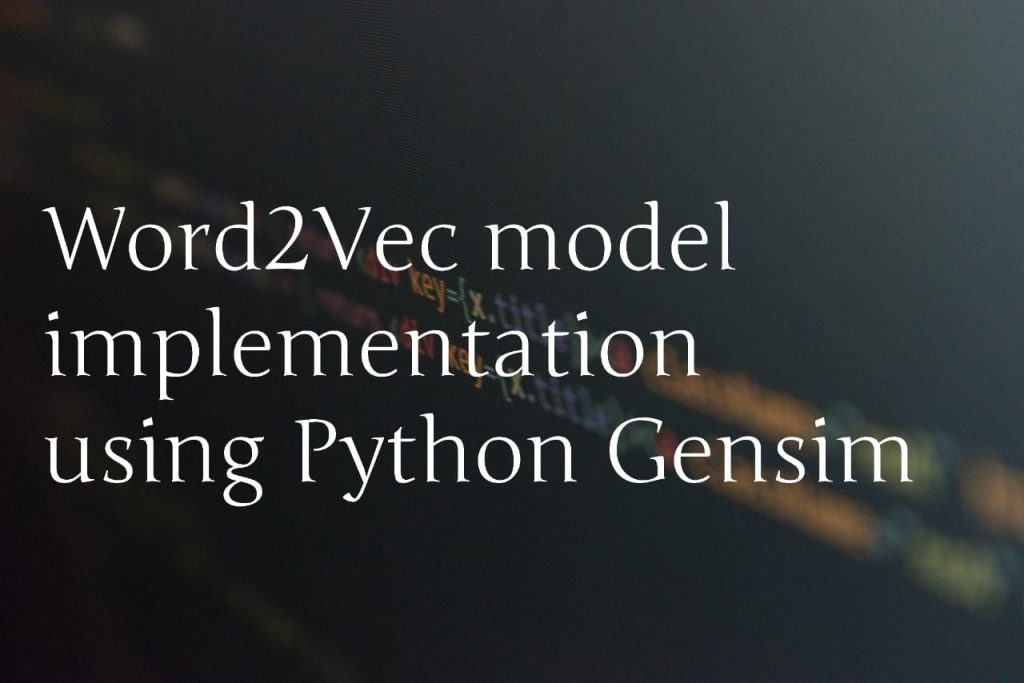

## Word2vec is a group of related models that are used to produce word embeddings.

Word2Vec creates vectors of the words that are distributed numerical representations of word features – these word features could comprise of words that represent the context of the individual words present in our vocabulary. 

Word embeddings eventually help in establishing the association of a word with another similar meaning word through the created vectors.

In [ ]:
!pip install distance
!pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
from bs4 import BeautifulSoup

In [ ]:
df = pd.read_csv(r"C:\Data\train.csv")

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df.shape

(404290, 6)

In [ ]:
df = df.dropna(how="any").reset_index(drop=True)

In [ ]:
df.shape

(404287, 6)

<Axes: xlabel='is_duplicate'>

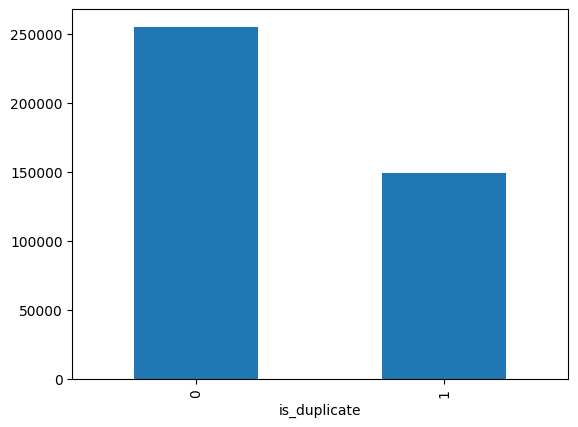

In [ ]:
df.groupby('is_duplicate')['id'].count().plot.bar()

In [ ]:
df['is_duplicate'].value_counts(normalize = True)

0    0.630799
1    0.369201
Name: is_duplicate, dtype: float64

- Similar question pair - 36.92%

- Non-Similar question pair - 63.07%

## Number of Unique Questions

In [ ]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qids = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)

print ('Total number of  Unique Questions are: {}\n'.format(unique_qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qids*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))


Total number of  Unique Questions are: 537929

Number of unique questions that appear more than one time: 111778 (20.779322178205675%)

Max number of times a single question is repeated: 157



## checking whether there are any repeated pair of questions

In [ ]:
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


### Data cleaning

In [27]:
import nltk
nltk.download('stopwords')
# Downloading wordnet before applying Lemmatizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [19]:
#Cleaning
SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}

from string import punctuation
stop_words = stopwords.words('english')

def clean(text, stem_words=True):

    
    if pd.isnull(text):
        return ''

    if type(text) != str or text=='':
        return ''
    ps = PorterStemmer()
    
    text = re.sub("\'s", " ", text) 
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    
       # Return a list of words
    text = ' '.join([word for word in text.split(" ") if word not in stop_words]).lower()
    #text = ' '.join([ps.stem(word) for word in text])
    return text

In [20]:
df['question1'] = df['question1'].apply(clean)
df['question2'] = df['question2'].apply(clean)

In [21]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0


## Feature Engineering

* Feature engineering is a way where we come up with meaningful features from the already existing features. There is a lot of scope for feature engineering in this project. 
* Let's explore and find ways in which we can find the similarity between two questions.

In [22]:
import gensim
import smart_open
from gensim.models import Word2Vec

* For several text similarity calculation we need to convert the texts to the representable embedding vectors on which distance could be calculated.
* We could use Gensim Google Word2Vec which embeds each word to 300 dimension vector.
* We could also create our own embedding. For simplicity we use Gensim Word2Vec which is based on huge corpus of text. Let's load it !!

In [23]:
import gensim
import gensim.downloader as api

print(gensim.__version__)

print(list(gensim.downloader.info()['models'].keys()))

4.3.1
['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [24]:
wv = api.load('glove-wiki-gigaword-300')

[=================================================-] 100.0% 375.9/376.1MB downloaded

In [25]:
def sent2vec(s):
    words = str(s).lower() #lower the sentence
    words = word_tokenize(words) #tokenize the sentence
    words = [w for w in words if not w in stop_words] #Filter out the stop words
    words = [w for w in words if w.isalpha()] #Filter out non-alpha characters
    M = []
    for w in words:#loop through each word in the sentence
        try:
            M.append(wv[w])#Gensim model converts each word in the sentence to a 300-dim vector space and appends to a list.
        except:
            continue
    M = np.array(M) #convert the list to array. Shape = (num_of_words_in_sentence,300)
    v = M.sum(axis=0) #Sum up along the num_of_words_in_sentence through 300-dim. Shape = (1,300) 
    return v / np.sqrt((v ** 2).sum()) #normalize the values with the sum

In [28]:
from tqdm import tqdm_notebook #for parallel processing

question1_vectors = np.zeros((df.shape[0], 300)) #vector matrix of shape = (num_of_rows,300) for question 1
for i, q in enumerate(tqdm_notebook(df.question1.values)):
    question1_vectors[i, :] = sent2vec(q) #function call for each question 1
    
question2_vectors  = np.zeros((df.shape[0], 300)) #vector matrix of shape = (num_of_rows,300) for question 2
for i, q in enumerate(tqdm_notebook(df.question2.values)):
    question2_vectors[i, :] = sent2vec(q) #function call for each question 2

<ipython-input-28-39866f9955f8>:4: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/404287 [00:00<?, ?it/s]

<ipython-input-25-2f2aacb9582d>:14: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-28-39866f9955f8>:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/404287 [00:00<?, ?it/s]

### Cosine distance

It is the compliment of the cosine similarity. Cosine similarity finds the angle between two text vectors in higher dimensional space. If cos(theta) is small then the cosine distance is large and vice-versa.
* Hence Inversly proportional. 
           Cosine distance = 1 - Cosine similarity

### Mahattan or City-block distance

Manhattan Distance is preferred over the Euclidean distance metric as the dimension of the data increases. This occurs due to something known as the ‘curse of dimensionality’.

### Jaccard distance

It is defined as size of intersection divided by size of union of two sets.

### Fuzz_ratio

It is a ratio function that computes the standard Levenshtein distance similarity ratio between two sequences.

### Fuzz_partial_ratio

This function allows us to perform substring matching. This works by taking the shortest string and matching it with all substrings that are of the same length.

### Fuzz_token_sort_ratio

This function sorts the strings alphabetically and then joins them together. Then, the fuzz.ratio() is calculated. This can come in handy when the strings you are comparing are the same in spelling but are not in the same order.

### Fuzz_token_set_ratio

The token_set_ratio() function is similar to the token_sort_ratio() function above, except it takes out the common tokens before calculating the fuzz.ratio() between the new strings.
    This function is the most helpful when applied to a set of strings with a significant difference in lengths.

In [ ]:
import distance
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis

from fuzzywuzzy import fuzz


### Let's apply all these feature engineering techniques on the data

In [30]:
df['len_q1'] = df.question1.apply(lambda x: len(str(x)))
df['len_q2'] = df.question2.apply(lambda x: len(str(x)))
df['common_words'] = df.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)

In [31]:
# Fuzzy
df['fuzz_ratio'] = df.apply(lambda x: fuzz.ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_partial_token_set_ratio'] = df.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_partial_token_sort_ratio'] = df.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)

In [33]:
# Distances
df['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]

/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:1157: RuntimeWarning:

invalid value encountered in double_scalars



In [34]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,...,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0,47,41,5,93,...,92,100,93,0.033067,3.562469,1.0,89.439283,0.257166,0.115104,0.159782
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0,41,77,3,66,...,82,91,64,0.504745,13.048161,1.0,183.543221,1.004734,0.507498,0.613816
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0,51,41,3,48,...,80,67,67,0.190421,8.554435,1.0,148.870227,0.617124,0.276275,0.372139
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0,38,49,0,11,...,29,28,25,0.546846,14.241201,1.0,192.699511,1.045798,0.478082,0.667696
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0,69,36,1,34,...,71,63,48,0.293943,10.575400,1.0,167.870487,0.766738,0.351893,0.471646


In [35]:
df.to_csv('quora_df.csv',index=False)

In [37]:
df.drop(['id','qid1','qid2','question1','question2'],axis = 1,inplace = True)

In [38]:
df.head(2)

,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance
0,0,47,41,5,93,98,100,92,100,93,0.033067,3.562469,1.0,89.439283,0.257166,0.115104,0.159782
1,0,41,77,3,66,85,100,82,91,64,0.504745,13.048161,1.0,183.543221,1.004734,0.507498,0.613816


In [39]:
df.shape

(404287, 17)

In [40]:
df.dropna(axis = 0,inplace = True)

In [42]:
df = df[['len_q1','len_q2','common_words','fuzz_ratio','fuzz_partial_ratio','fuzz_partial_token_sort_ratio','fuzz_token_set_ratio','fuzz_token_sort_ratio','canberra_distance', 'cosine_distance','cityblock_distance','jaccard_distance','euclidean_distance',
                'minkowski_distance','is_duplicate']] # Reanrrange the features

## Segregating the data to input and output

In [43]:
y = df['is_duplicate'] 
X = df[['len_q1','len_q2','common_words','fuzz_ratio','fuzz_partial_ratio','fuzz_token_set_ratio','fuzz_token_sort_ratio','canberra_distance', 'cosine_distance','cityblock_distance','euclidean_distance',
                'minkowski_distance']]

In [44]:
from sklearn.model_selection import train_test_split

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## segregating the Numerical features of Train Data

In [46]:
X_train_num = X_train.select_dtypes(include = ['int64', 'float64']) 

In [47]:
# scaling the numerical features
from sklearn.preprocessing import StandardScaler

Std_scaler = StandardScaler()

X_train_trns = pd.DataFrame(Std_scaler.fit_transform(X_train_num),
                                     columns = X_train_num.columns,
                                     index = X_train_num.index)
X_train_trns.head()

,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,canberra_distance,cosine_distance,cityblock_distance,euclidean_distance,minkowski_distance
165624,-0.012271,0.846044,1.120750,0.711166,0.358029,0.980195,0.673491,-0.485724,-0.746500,-0.661773,-0.699743,-0.730799
253997,-0.960799,-0.593752,-1.417369,-1.070557,-1.248901,-2.043991,-1.766669,0.508652,0.529589,0.699414,0.700964,0.721691
153684,-0.960799,-0.429204,-1.417369,-1.344668,-1.870938,-2.450224,-2.205898,1.658173,3.510634,2.594425,2.524759,2.417193
59494,0.574913,0.023303,0.105503,-0.750760,-1.145228,-0.735015,-0.546589,0.065309,-0.331194,-0.104540,-0.127095,-0.146956
108477,-0.599455,0.640359,0.613127,0.025888,0.409865,0.754509,-0.204967,-0.169741,-0.466803,-0.275858,-0.293190,-0.330262


## segregating the Numerical features of Test Data

In [48]:
X_test_num = X_test.select_dtypes(include = ['int64', 'float64']) 

In [49]:
X_test_trns = pd.DataFrame(Std_scaler.transform(X_test_num),
                                    columns = X_test_num.columns,
                                    index = X_test_num.index)
X_test_trns.head()

,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,canberra_distance,cosine_distance,cityblock_distance,euclidean_distance,minkowski_distance
344164,-0.554287,-0.634889,-0.909745,-0.705075,-1.093391,-0.780152,-0.400179,0.192571,0.190373,0.360648,0.408457,0.421945
98151,-0.102607,2.491525,-0.909745,-0.933501,-0.575027,-1.637757,-1.473850,1.276017,1.433280,1.403984,1.359152,1.278967
36619,0.845921,0.558085,1.120750,-0.065482,-0.471354,0.980195,1.112720,0.363171,0.349978,0.616412,0.550219,0.474132
200148,0.213569,1.010592,0.613127,-0.156853,-0.678700,0.258001,0.234262,0.222833,0.106766,0.346993,0.330799,0.299557
268056,0.710417,-0.922848,-0.402121,-0.568020,-0.367681,0.167727,-0.644195,0.419602,0.221089,0.411576,0.436371,0.449013


# Model Building

## Logistic Regression

In [50]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

cls = LogisticRegression()
cls.fit(X_train_trns, y_train)

# prediction on train
y_train_pred = cls.predict(X_train_trns)


print('-'*10,'Prediction on train','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))


# prediction on test
y_test_pred = cls.predict(X_test_trns)


print('-'*10,'Prediction on test','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

---------- Prediction on train ----------
[[135408  43042]
 [ 46923  57330]]
              precision    recall  f1-score   support

           0       0.74      0.76      0.75    178450
           1       0.57      0.55      0.56    104253

    accuracy                           0.68    282703
   macro avg       0.66      0.65      0.66    282703
weighted avg       0.68      0.68      0.68    282703

---------- Prediction on test ----------
[[57860 18314]
 [20476 24509]]
              precision    recall  f1-score   support

           0       0.74      0.76      0.75     76174
           1       0.57      0.54      0.56     44985

    accuracy                           0.68    121159
   macro avg       0.66      0.65      0.65    121159
weighted avg       0.68      0.68      0.68    121159



## GridSearch CV

In [51]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import RidgeClassifier

tuned_parameters = [{'alpha':[x for x in range(1,10)]}]

clf = GridSearchCV(
    estimator=RidgeClassifier(), 
    param_grid=tuned_parameters, 
    scoring='f1',
    cv=5,
    return_train_score=True,
    verbose=1
)
clf.fit(X_train_trns, y_train)

print("Best parameters set found on train set:")
print(clf.best_params_)
print(clf.best_estimator_)

y_p = clf.predict(X_test_trns)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters set found on train set:
{'alpha': 1}
RidgeClassifier(alpha=1)


## Evaluation Metrics

In [52]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [53]:
# Evaluating the model using the Evaluation metrics
print(f1_score(y_test, y_p)) 
print(classification_report(y_test, y_p))

0.5420928588263021
              precision    recall  f1-score   support

           0       0.73      0.78      0.75     76174
           1       0.58      0.51      0.54     44985

    accuracy                           0.68    121159
   macro avg       0.65      0.64      0.65    121159
weighted avg       0.67      0.68      0.67    121159



## AdaBoost Classifier

In [54]:
from sklearn.ensemble import AdaBoostClassifier

cls1 = AdaBoostClassifier()
cls1.fit(X_train_trns, y_train)

# prediction on train
y_train_pred1 = cls1.predict(X_train_trns)

print('-'*10,'Prediction on train','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_train, y_train_pred1))
print(classification_report(y_train, y_train_pred1))

# prediction on test
y_test_pred1 = cls1.predict(X_test_trns)

print('-'*10,'Prediction on test','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_test, y_test_pred1))
print(classification_report(y_test, y_test_pred1))

---------- Prediction on train ----------
[[133879  44571]
 [ 34316  69937]]
              precision    recall  f1-score   support

           0       0.80      0.75      0.77    178450
           1       0.61      0.67      0.64    104253

    accuracy                           0.72    282703
   macro avg       0.70      0.71      0.71    282703
weighted avg       0.73      0.72      0.72    282703

---------- Prediction on test ----------
[[57243 18931]
 [14759 30226]]
              precision    recall  f1-score   support

           0       0.80      0.75      0.77     76174
           1       0.61      0.67      0.64     44985

    accuracy                           0.72    121159
   macro avg       0.70      0.71      0.71    121159
weighted avg       0.73      0.72      0.72    121159



## Gradient Boosting Classifier

In [55]:
from sklearn.ensemble import GradientBoostingClassifier
cls2 = GradientBoostingClassifier()
cls2.fit(X_train_trns, y_train)

# prediction on train
y_train_pred2 = cls2.predict(X_train_trns)

print('-'*10,'Prediction on train','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_train, y_train_pred2))
print(classification_report(y_train, y_train_pred2))

# prediction on test
y_test_pred2 = cls2.predict(X_test_trns)

print('-'*10,'Prediction on test','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_test, y_test_pred2))
print(classification_report(y_test, y_test_pred2))

---------- Prediction on train ----------
[[132732  45718]
 [ 27886  76367]]
              precision    recall  f1-score   support

           0       0.83      0.74      0.78    178450
           1       0.63      0.73      0.67    104253

    accuracy                           0.74    282703
   macro avg       0.73      0.74      0.73    282703
weighted avg       0.75      0.74      0.74    282703

---------- Prediction on test ----------
[[56741 19433]
 [12169 32816]]
              precision    recall  f1-score   support

           0       0.82      0.74      0.78     76174
           1       0.63      0.73      0.67     44985

    accuracy                           0.74    121159
   macro avg       0.73      0.74      0.73    121159
weighted avg       0.75      0.74      0.74    121159



## XGBoost Classifier

In [56]:
import xgboost as xgb
from xgboost import XGBClassifier
cls3 = XGBClassifier()
cls3.fit(X_train_trns, y_train)

# prediction on train
y_train_pred3 = cls3.predict(X_train_trns)

print('-'*10,'Prediction on train','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_train, y_train_pred3))
print(classification_report(y_train, y_train_pred3))

# prediction on test
y_test_pred3 = cls3.predict(X_test_trns)

print('-'*10,'Prediction on test','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_test, y_test_pred3))
print(classification_report(y_test, y_test_pred3))

---------- Prediction on train ----------
[[140844  37606]
 [ 25923  78330]]
              precision    recall  f1-score   support

           0       0.84      0.79      0.82    178450
           1       0.68      0.75      0.71    104253

    accuracy                           0.78    282703
   macro avg       0.76      0.77      0.76    282703
weighted avg       0.78      0.78      0.78    282703

---------- Prediction on test ----------
[[59061 17113]
 [12545 32440]]
              precision    recall  f1-score   support

           0       0.82      0.78      0.80     76174
           1       0.65      0.72      0.69     44985

    accuracy                           0.76    121159
   macro avg       0.74      0.75      0.74    121159
weighted avg       0.76      0.76      0.76    121159



## Stacking Classifier

In [57]:
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

estimators = [
    ('LR', LogisticRegression()),
    ("GNB",GaussianNB()),
    ('DT',DecisionTreeClassifier(random_state=42),
    'XGb',XGBClassifier(),
      'RC',RidgeClassifier(),
     'RF',RandomForestClassifier(),
     'GBDT',GradientBoostingClassifier())
]

stack_cls = StackingClassifier(estimators=estimators,
                                      final_estimator=XGBClassifier())

stack_cls.fit(X_train_trns, y_train)


# Prediction on test data
y_test_pred4 = stack_cls.predict(X_test_trns)

print('-'*10,'on test','-'*10)
# Evaluation on test data
print(confusion_matrix(y_test, y_test_pred4))
print(classification_report(y_test, y_test_pred4))

---------- on test ----------
[[61229 14945]
 [19011 25974]]
              precision    recall  f1-score   support

           0       0.76      0.80      0.78     76174
           1       0.63      0.58      0.60     44985

    accuracy                           0.72    121159
   macro avg       0.70      0.69      0.69    121159
weighted avg       0.72      0.72      0.72    121159



# Conclusion

*  The results of the evaluation using `Accuracy` as the metric show that **`XGBoost`** outperformed the other models, with a score of **76**

####  These results suggest that **`XGBoost`** may be the most effective model for this particular task, 
   >  Although further evaluation and validation is necessary to confirm this conclusion.

In [58]:
from pickle import dump

dump(cls, open(r"/content/drive/MyDrive/Quora\LR_cls.pkl", 'wb'))
dump(stack_cls, open(r"/content/drive/MyDrive/Quora\stack_cls.pkl", 'wb'))
dump(clf, open(r"/content/drive/MyDrive/Quora\LR_HYP.pkl", 'wb'))
dump(cls1, open(r"/content/drive/MyDrive/Quora\ADA_cls.pkl", 'wb'))
dump(cls2, open(r"/content/drive/MyDrive/Quora\GBDT_cls.pkl", 'wb'))
dump(cls3, open(r"/content/drive/MyDrive/Quora\XGB_cls.pkl", 'wb'))

In [2]:
quora_df = pd.read_csv(r"C:\Users\prave\Downloads\quora_df.csv")

In [6]:
quora_df.isna().sum()

id                                 0
qid1                               0
qid2                               0
question1                          6
question2                          1
is_duplicate                       0
len_q1                             0
len_q2                             0
common_words                       0
fuzz_ratio                         0
fuzz_partial_ratio                 0
fuzz_partial_token_set_ratio       0
fuzz_partial_token_sort_ratio      0
fuzz_token_set_ratio               0
fuzz_token_sort_ratio              0
cosine_distance                    0
cityblock_distance                 0
jaccard_distance                   0
canberra_distance                  0
euclidean_distance                 0
minkowski_distance                 0
braycurtis_distance              425
dtype: int64

## Experiment Tracking with mlflow

In [4]:
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

mlflow.autolog()
# Separating the input and output variables.
y = quora_df['is_duplicate'] 
X = quora_df[['len_q1','len_q2','common_words','fuzz_ratio','fuzz_partial_ratio','fuzz_token_set_ratio',
        'fuzz_token_sort_ratio','canberra_distance', 'cosine_distance','cityblock_distance','euclidean_distance',
                'minkowski_distance']]

# Separating the train and test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.80, random_state = 20)

#Separating the numerical data from the train data
X_train_num = X_train.select_dtypes(include=['int64', 'float64'])

#Separating the numerical data from the test data
X_test_num = X_test.select_dtypes(include=['int64', 'float64'])

# Rescaling the train Numerical data
scaler = StandardScaler()
X_train_transformed = pd.DataFrame(scaler.fit_transform(X_train_num),
                                      columns= X_train_num.columns,
                                      index= X_train_num.index)

# Rescaling the test Numerical data.
X_test_transformed = pd.DataFrame(scaler.transform(X_test_num), 
                                   columns = X_test_num.columns, 
                                   index = X_test_num.index)

# Training and Testing the data
classifier = GradientBoostingClassifier()
classifier.fit(X_train_transformed, y_train)
y_test_predicted = classifier.predict(X_test_transformed)
print('Mean accuracy score: ', metrics.accuracy_score(y_test, y_test_predicted))

2023/06/06 11:44:56 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/06/06 11:45:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/06/06 11:45:01 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

2023/06/0

Mean accuracy score:  0.7381458853793069


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
mlflow.sklearn.autolog(max_tuning_runs=None)

with mlflow.start_run():
    tuned_parameters = [{'max_depth':[i for i in range(1, 51)]}]
    clf = GridSearchCV(
        estimator=GradientBoostingClassifier(), 
        param_grid=tuned_parameters, 
        scoring='accuracy',
        cv=5,
        return_train_score=True,
        verbose=1
    )
    clf.fit(X_train_transformed, y_train)
    # Disabling autologging
    mlflow.sklearn.autolog(disable=True)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [5]:
pwd/

'C:\\Users\\prave\\Data Science INN\\3_Internship'

## Link for Mlops 

http://127.0.0.1:5000/#/experiments/0?searchFilter=&orderByKey=attributes.start_time&orderByAsc=false&startTime=ALL&lifecycleFilter=Active&modelVersionFilter=All%20Runs&selectedColumns=attributes.%60Source%60,attributes.%60Models%60&isComparingRuns=false&compareRunCharts=

! 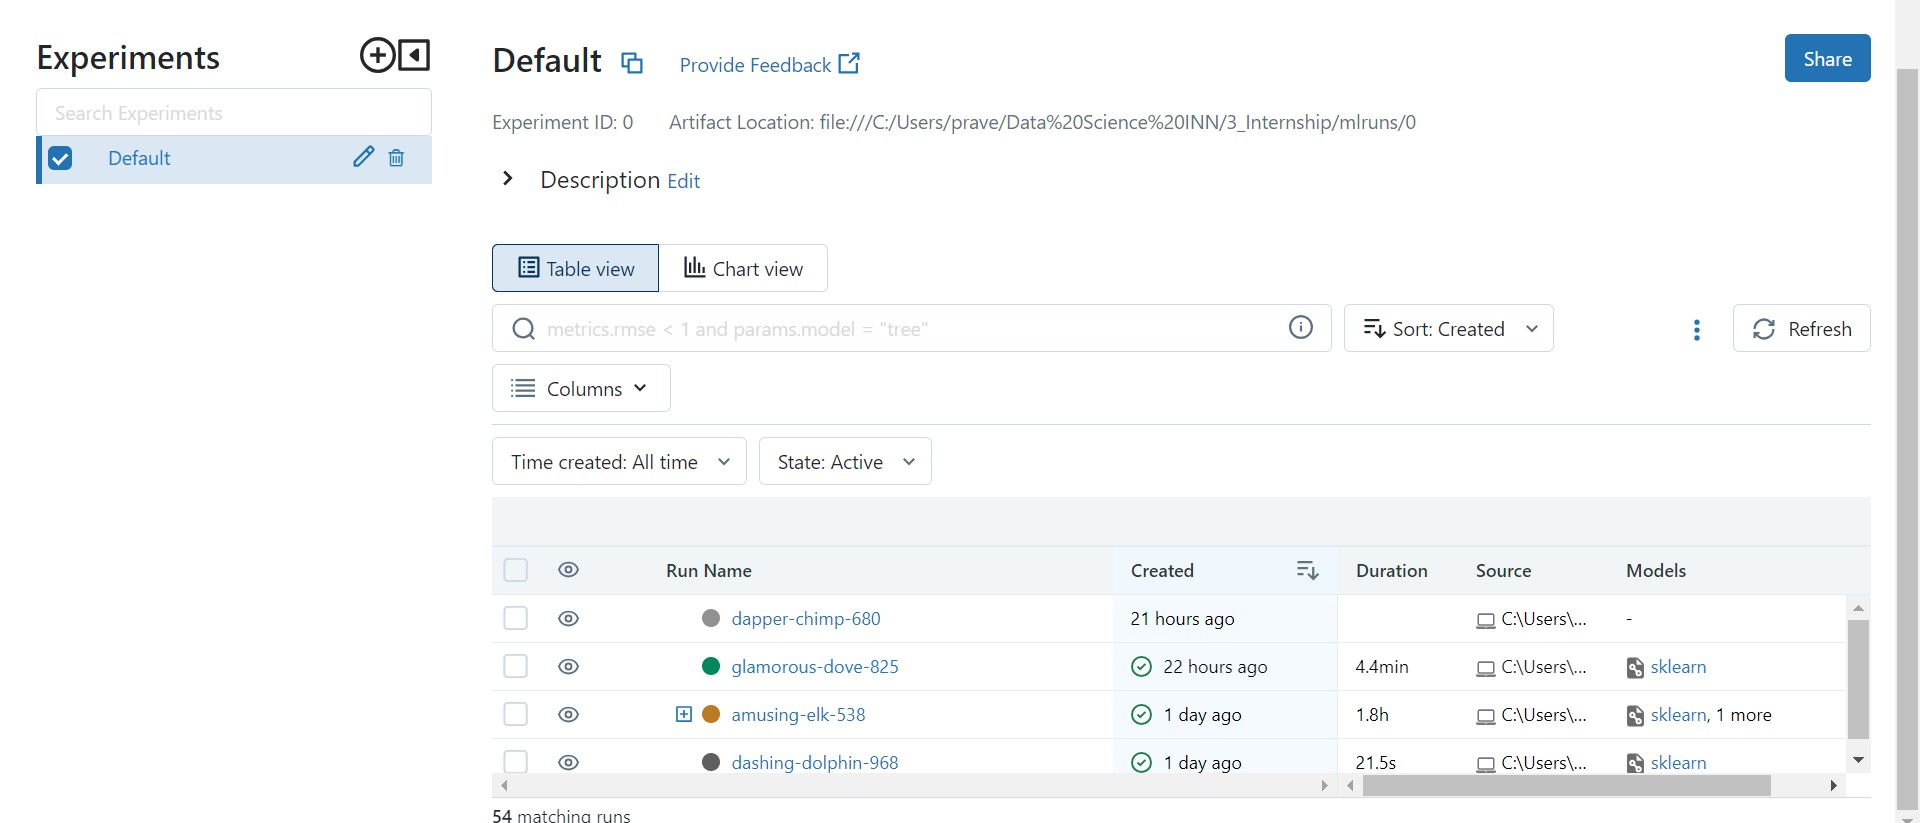

! 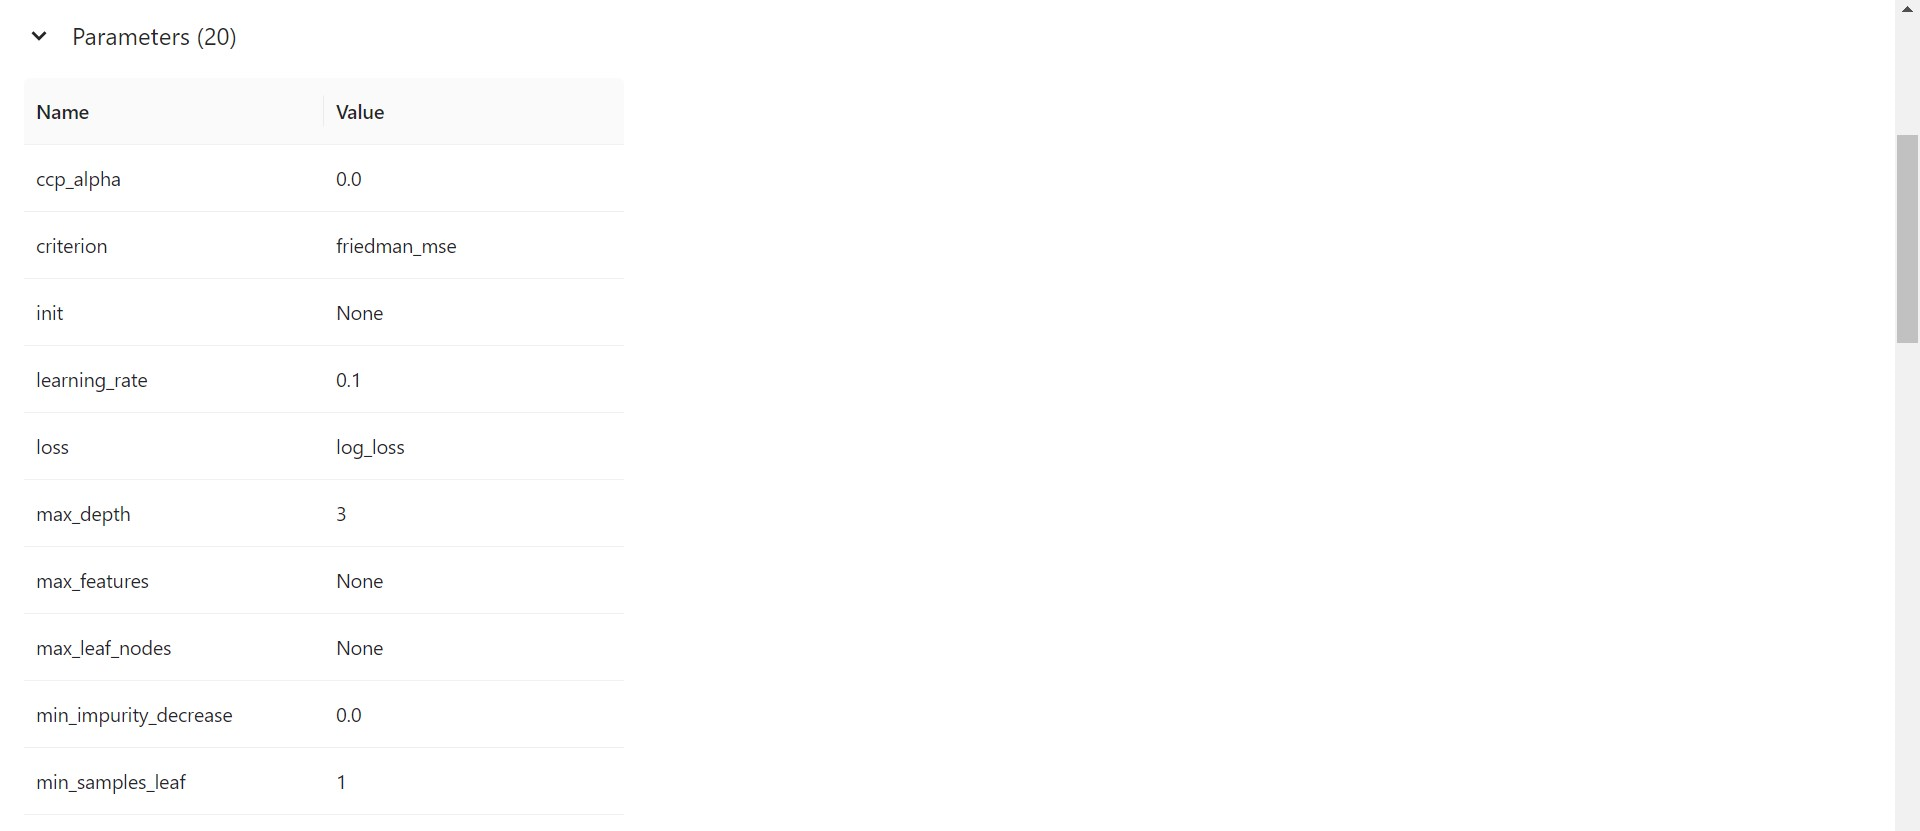

! 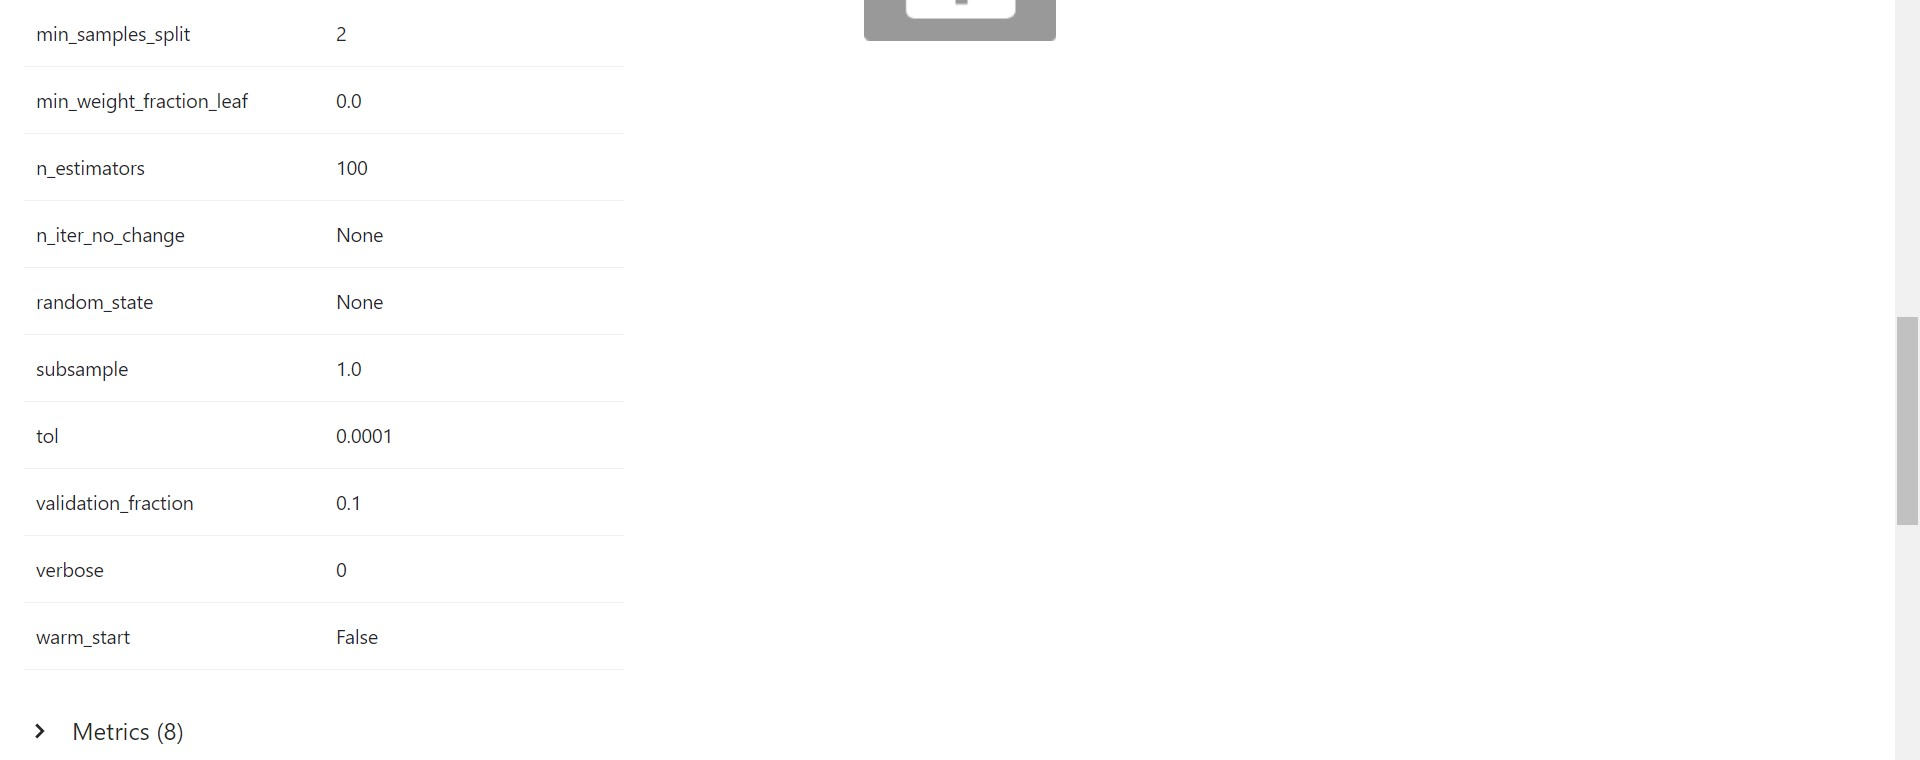

! 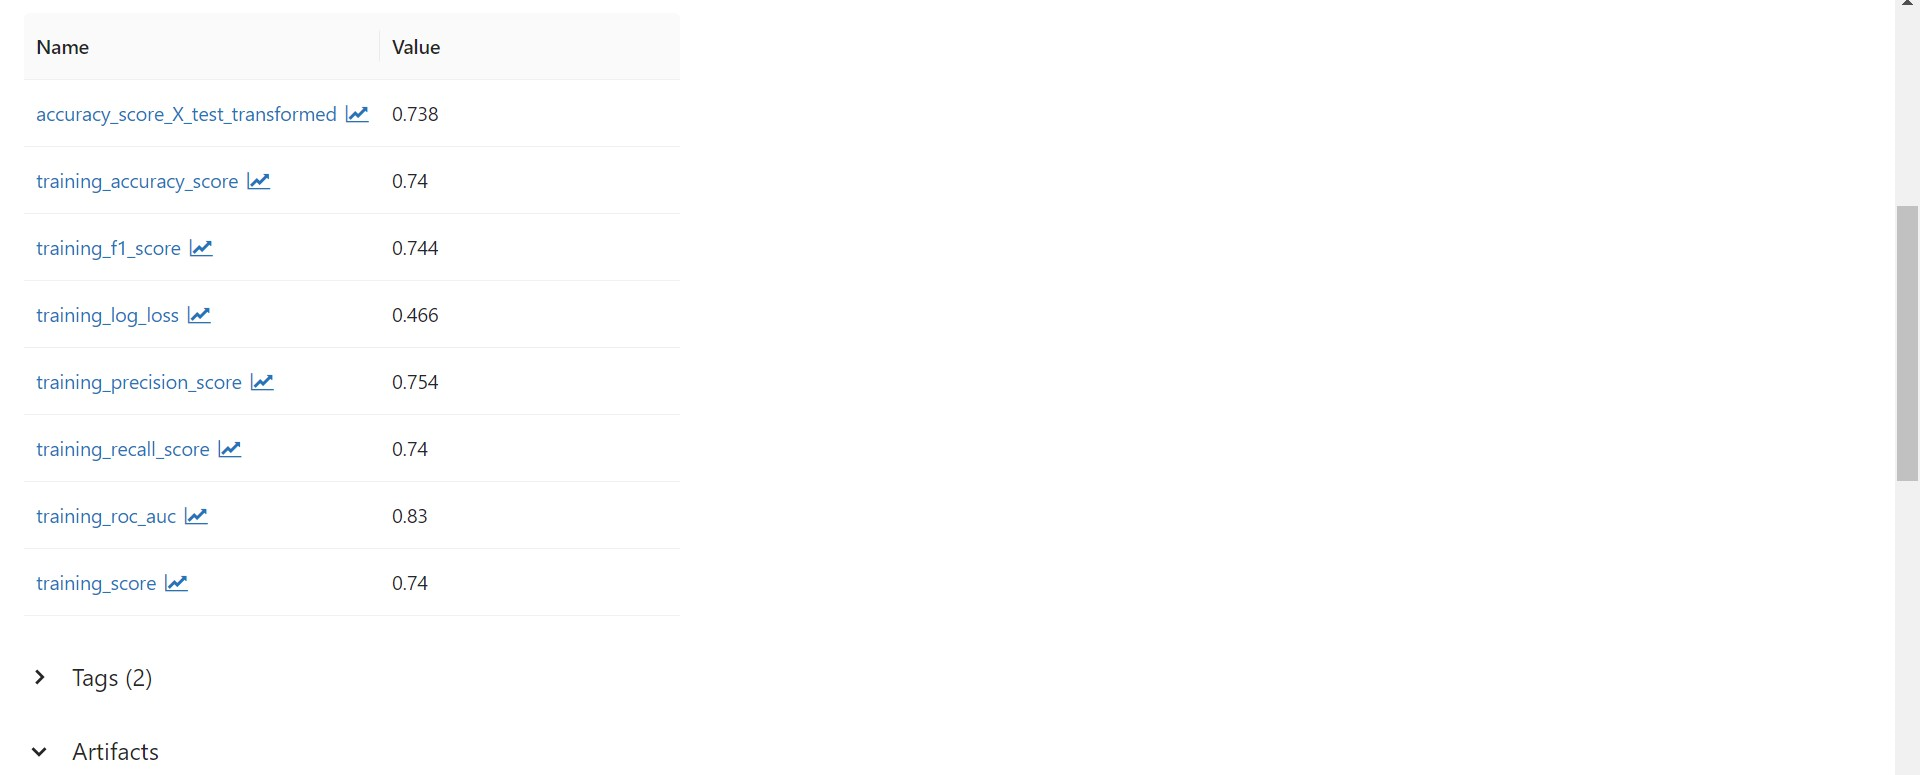

! 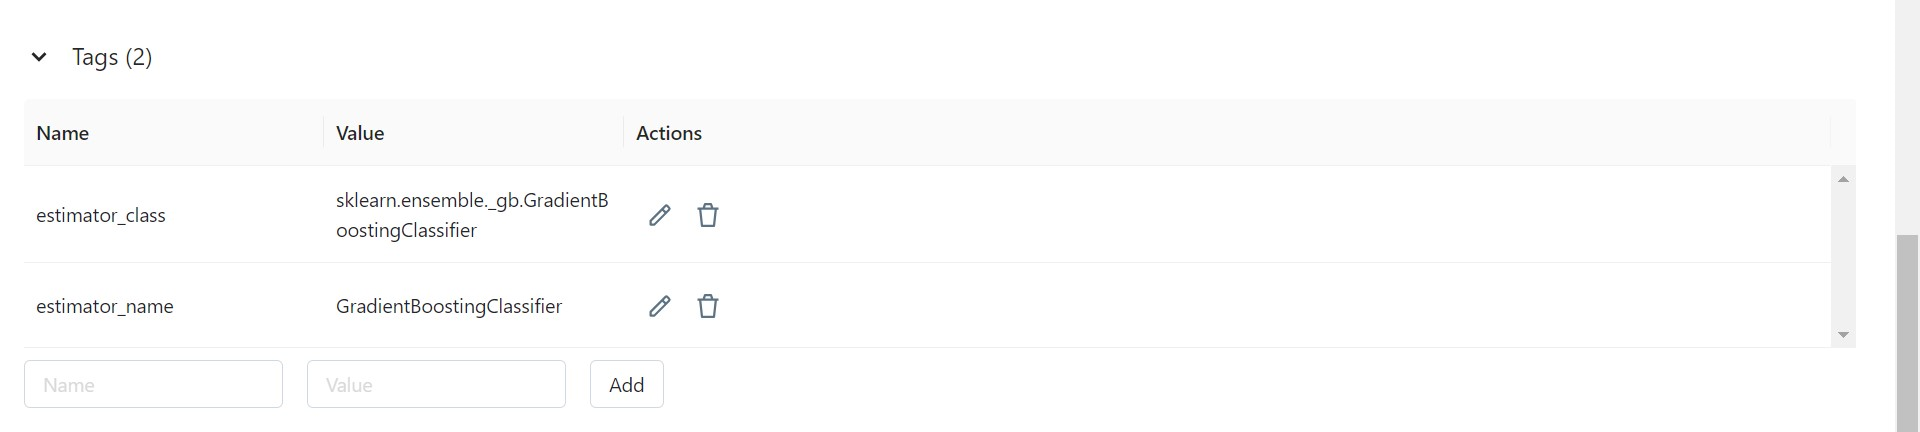

! 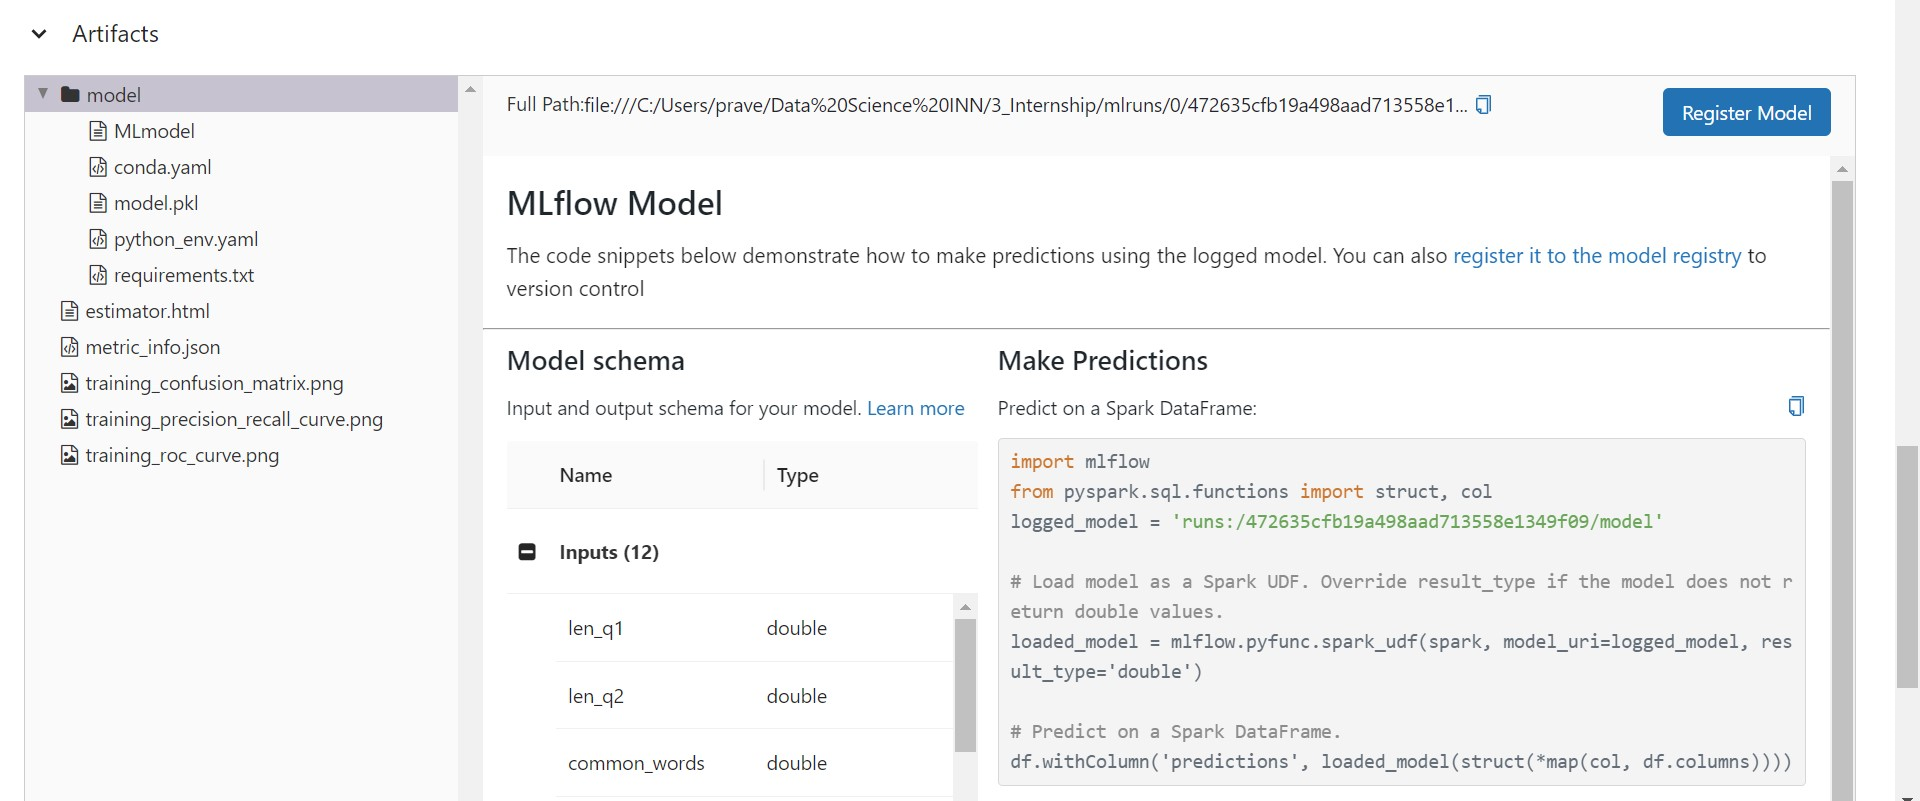